# 北尾早霧・砂川武貴・山田知明『定量的マクロ経済学と数値計算』日本評論社
## 第2章：2期間モデル・3期間モデルと数値計算の概観

## 2.3.3 状態変数と操作変数が共に離散の場合
* 話をもどして、ようやく数値計算の本筋に入っていこう！

2期目の消費は
$$
    c_{2} = (1+r)a
$$
なので、aのグリッドに対応した効用を確認してみよう

In [15]:
import numpy as np # numpyモジュールをnpという名前でインポートする

In [16]:
β = 0.985**30
γ = 2.0
rent = 1.025**30 - 1.0
nw = 10
w_max = 1.0
w_min = 0.1
na = 40
a_max = 1.0
a_min = 0.025

grid_w = np.linspace(w_min,w_max,nw)
grid_a = np.linspace(a_min,a_max,na)

In [17]:
class Models:
    def __init__(self,β:float,γ:float,rent:float,nw:int,w_max:float,w_min:float,grid_w:"np.ndarray[np.float64]",na:int,a_max:float,a_min:float,grid_a:"np.ndarray[np.float64]"):
        # パラメータ
        self.β = β # 割引因子
        self.γ = γ # 相対的危険回避度

        # 要素価格
        self.rent = rent # 純利子率

        # グリッド
        self.nw = nw # 所得グリッドの数
        self.w_max = w_max # 所得グリッドの最大値
        self.w_min = w_min # 所得グリッドの最小値 
        self.grid_w = grid_w # 所得グリッド
        self.na = na # 貯蓄グリッドの数
        self.a_max = a_max # 貯蓄グリッドの最大値
        self.a_min = a_min # 貯蓄グリッドの最小値
        self.grid_a = grid_a # 貯蓄グリッド

In [18]:
# class の使い方
Models(β, γ, rent, nw, w_max, w_min, grid_w, na, a_max, a_min, grid_a)

In [19]:
def Calibration():
    # パラメータはここで設定をする
    β = 0.985**30
    γ = 2.0
    rent = 1.025**30 - 1.0
    nw = 10
    w_max = 1.0
    w_min = 0.1
    na = 40
    a_max = 1.0
    a_min = 0.025

    grid_w = np.linspace(w_min,w_max,nw)
    grid_a = np.linspace(a_min,a_max,na)

    return Models(β, γ, rent, nw, w_max, w_min, grid_w, na, a_max, a_min, grid_a)

In [20]:
# paramsという変数に色々な変数をひとまとめにする
params = Calibration()

In [21]:
def CRRA(cons,γ):
    """
    "機能の説明を書くスペース"
    効用関数を計算(この関数はどう使うのか。目的や使いみちを書いておく。)
    
    ### インプット(書かなくても機能上は問題ないけど、ヘルプにインプットとアウトプットの情報が書いてあったほうが便利)
    `cons::Real` 消費,
    `γ::Real` 相対的リスク回避度
    ### アウトプット(同上)
    効用
    """
    if γ != 1.0: # 条件分岐の際も:(コロン)を条件文の後に書く
        return cons**(1.0 - γ) / (1.0 - γ)
    else:
        return np.log(cons)

In [22]:
# 2期の効用関数として取りうる値
util2 = CRRA((1.0 + params.rent)*params.grid_a, params.γ)

#### Tips：上の書き方では関数のブロードキャストという方法を使っている
* 関数`CRRA(c, \gamma)`の変数cと\gammaはスカラーである必要がある
* `CRRA(cのベクトル, \gamma)`とすると、スカラーではなく、ベクトルのそれぞれの値に対応したCRRA関数を計算をするという形になる
    * `model.grid_a`はスカラーではなく⬆で定義したベクトルである点に注意
    * ループ計算(後述)でも計算出来るけど、こちらのほうが簡潔にコードを書くことが出来る
    * JuliaやMatlabの場合、CRRA.(cのベクトル,\gamma)とする必要があるが、Pythonの場合は、直接ベクトルを引数としてもエラーは出ない。

### 試しに効用関数をプロットしてみよう

In [23]:
import matplotlib.pyplot as plt
!pip install japanize_matplotlib
import japanize_matplotlib

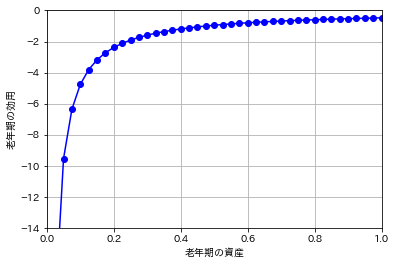

In [24]:
# 効用関数の図を描く
fig, ax = plt.subplots()
ax.plot(params.grid_a,util2,c="b",marker="o")
ax.set(xlim=(0,1),ylim=(-14,0),xlabel="老年期の資産",ylabel="老年期の効用")
ax.grid()
plt.show()

### 空の変数を作る
* ゼロが入っている変数：器の役割
    * ここに計算結果を代入していく
* 変数のサイズを予め決めておく点が重要
    * 計算途中でベクトルや行列のサイズが変わるような書き方をすると計算速度が**大幅に**低下する

In [25]:
# 配列(変数)をあらかじめ定義しておく
obj = np.zeros((params.na, params.nw)) # 目的関数
pol = np.zeros(params.nw) # 政策関数

## 今回のアルゴリズムの中心
* テキスト(2.5)式を計算

In [26]:
# あらゆる(w,a)の組み合わせについて生涯効用を計算

for i in range(params.nw):
    for j in range(params.na):
        
        cons = params.grid_w[i] - params.grid_a[j]
        
        if cons > 0.0:
            obj[j, i] = CRRA(cons, params.γ) + params.β*CRRA((1.0+params.rent)*params.grid_a[j], params.γ)
        else:
            # 消費が負値の場合、ペナルティを与えてその値が選ばれないようにする
            obj[j,i] = -10000.0

---

## Tips：ループ(繰り返し計算)とは?

In [27]:
# これを計算したいけど書くのが面倒
temp = 1 + 2 + 3 + 4 + 5 + 6 + 7 + 8 + 9 + 10

In [28]:
# (注意) Pythonのrange(n)は0~n-1の整数を等差1で返す。
a = 0
for i in range(10):
    a = a + (i+1) # =は同じではなく代入
print(a)

55


In [29]:
# 下記のような書き方も出来る
a = 0
for i in range(10):
    a += i+1 # =は同じではなく代入
print(a)

55


---

In [30]:
# 各wについて生涯効用を最大とするようなaを探す

for i in range(params.nw):

    maxl = np.argmax(obj[:,i]) # 最大値がある場所を探す
    maxv = obj[maxl,i] # そのmaximizerから最大値を求める

    # policy：最適貯蓄
    pol[i] = params.grid_a[maxl]

print(pol)

[0.025 0.075 0.1   0.15  0.175 0.225 0.25  0.275 0.325 0.35 ]


In [31]:
help(np.argmax)

Help on function argmax in module numpy:

argmax(a, axis=None, out=None, *, keepdims=<no value>)
    Returns the indices of the maximum values along an axis.
    
    Parameters
    ----------
    a : array_like
        Input array.
    axis : int, optional
        By default, the index is into the flattened array, otherwise
        along the specified axis.
    out : array, optional
        If provided, the result will be inserted into this array. It should
        be of the appropriate shape and dtype.
    keepdims : bool, optional
        If this is set to True, the axes which are reduced are left
        in the result as dimensions with size one. With this option,
        the result will broadcast correctly against the array.
    
        .. versionadded:: 1.22.0
    
    Returns
    -------
    index_array : ndarray of ints
        Array of indices into the array. It has the same shape as `a.shape`
        with the dimension along `axis` removed. If `keepdims` is set to True,
    

## これまでの計算過程をまとめて一つの関数にする

In [32]:
def discretize(params):
    """
    2期間モデルを離散化によって解く

    # インプット
    `m::Models`::パラメータの構造体

    # アウトプット
    `obj::Vector`::価値関数
    `pol::Vector`::政策関数
    """

    # 配列をあらかじめ定義しておく
    obj = np.zeros((params.na, params.nw))
    pol = np.zeros(params.nw) # 政策関数

    # あらゆる(w,a)の組み合わせについて生涯効用を計算
    for i in range(params.nw):
        for j in range(params.na):
            
            cons = params.grid_w[i] - params.grid_a[j]
        
            if cons > 0.0:
                obj[j,i] = CRRA(cons, params.γ) + params.β*CRRA((1.0+params.rent)*params.grid_a[j], params.γ)
            else:
                # 消費が負値の場合、ペナルティを与えてその値が選ばれないようにする
                obj[j,i] = -10000.0

    # 各wについて生涯効用を最大とするようなaを探す
    for i in range(params.nw):

        maxl = np.argmax(obj[:,i]) # 最大値がある場所を探す
        maxv = obj[maxl,i] # そのmaximizerから最大値を求める

        # policy：最適貯蓄
        pol[i] = params.grid_a[maxl]

    return obj, pol

## 実際に計算をしてみる

In [33]:
# 関数の実行
obj, pol = discretize(params)
print(pol)

[0.025 0.075 0.1   0.15  0.175 0.225 0.25  0.275 0.325 0.35 ]


---

In [34]:
# 計算速度を測る場合、time関数を使う
# ⬇の書き方で計算時間を測ってくれる

import time

start = time.time() # 計測開始
obj, pol = discretize(params)
end = time.time() - start # 計測終了

print(f"{end:.6} seconds") # 計算時間を出力する

0.0 seconds


---

## 計算結果を出力してみよう

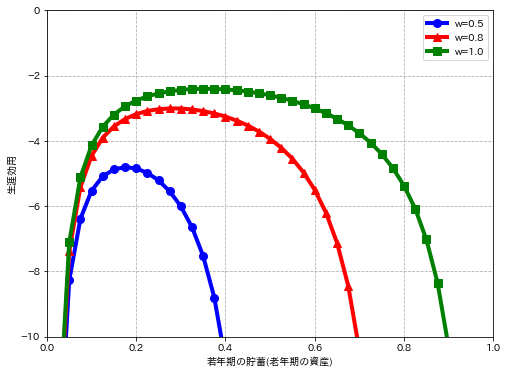

In [35]:
# 図2.1(a)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.grid_a, obj[:,4], c="b", marker="o", label="w=0.5", lw=4, ms=8)
ax.plot(params.grid_a, obj[:,7], c="r", marker="^", label="w=0.8", lw=4, ms=8)
ax.plot(params.grid_a, obj[:,9], c="g", marker="s", label="w=1.0", lw=4, ms=8)
ax.set(xlabel="若年期の貯蓄(老年期の資産)", ylabel="生涯効用", xlim=(0,1), ylim=(-10,0))
ax.legend()
ax.grid(ls="--")
plt.show()

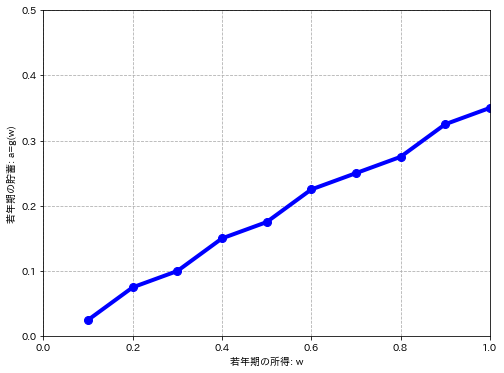

In [36]:
# 図2.1(b)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.grid_w, pol, c="b", marker="o", lw=4, ms=8)
ax.set(xlabel="若年期の所得: w", ylabel="若年期の貯蓄: a=g(w)", xlim=(0,1), ylim=(0,0.5))
ax.grid(ls="--")
plt.show()

---

## エクササイズ
* グリッドの数を増やして、政策関数の精度を高めてみよう。